In [1]:
cd /home/jovyan/lending_club

/home/jovyan/lending_club


In [2]:
import sys
import pandas as pd
import sqlite3
import csv
import time
import gc
from IPython.core.display import display, HTML
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

from lending_club import db, facets_wrapper, clean

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
data_dict_path = 'data/LCDataDictionary_dw.txt'
csv_path = 'data/lending-club-loan-data/loan.csv'
full_data_dict_path = 'data/LCDataDictionary_dw_types.tsv'
final_data_dict_path = 'data/LCDataDictionary_dw_types_final.txt'

test = False
test_load = 50000

# Part 1: Data Exploration and Evaluation

Data set is Lending Club’s loan origination data from 2007-2015. Data set (SQLite file and CSV file) and data dictionary were downloaded from https://www.kaggle.com/tuananhkk/lending-club-data-insights/data

## Data Dictionary

To begin, I reviewed the data dictionary provided with the data set and searched [Lending Club](https://www.lendingclub.com/investing/investor-education) and other documentation to familiarize myself with any new terms. I then started classifying data elements into a few broad categories:
* demographic information (demographics)
* loan information (loan)
* credit information (credit)
* calculated by LC (LC_calcs)
* loan outcomes (outcomes)

Demographic and requested loan information are provided by the applicant on the application. Lending Club then obtains the applicant's credit information from credit bureaus, including credit score, debt-to-income ratio, credit history length, and recent credit activity.

Lending Club uses information provided by the applicant and credit bureaus to conduct an initial credit screening, and then uses a proprietary scoring model to either decline the applicant or assign a Loan Grade, Sub-Grade, and interest rate [[source](https://www.lendingclub.com/foliofn/rateDetail.action)]. In the data set, I assigned these elements to the LC_calcs category.

Finally, the data set includes measures of performance, such as principal payments, interest payments, fees, and associated dates. I classified these data elements as loan outcomes.

In [4]:
# Load data dict with DW annotations
data_dict = pd.read_csv(data_dict_path, sep='\t', encoding = "ISO-8859-1")
print(data_dict.shape)
data_dict.head()

(78, 8)


,dw_notes,demographics,loan,credit,LC_calcs,outcomes,LoanStatNew,description
0,NaN,NaN,NaN,1.0,NaN,NaN,acc_now_delinq,The number of accounts on which the borrower i...
1,NaN,1.0,NaN,NaN,NaN,NaN,addr_state,The state provided by the borrower in the loan...
2,NaN,NaN,NaN,1.0,NaN,NaN,all_util,Balance to credit limit on all trades
3,NaN,1.0,NaN,NaN,NaN,NaN,annual_inc,The self-reported annual income provided by th...
4,NaN,1.0,NaN,NaN,NaN,NaN,annual_inc_joint,The combined self-reported annual income provi...


In [5]:
# Load table info from sqlite including types
query = """
PRAGMA table_info(loan);
"""
table_info = db.sql_to_df(query)
print(table_info.shape)
table_info.head()

(75, 6)


,cid,name,type,notnull,dflt_value,pk
0,0,index,BIGINT,0,None,0
1,1,id,TEXT,0,None,0
2,2,member_id,FLOAT,0,None,0
3,3,loan_amnt,FLOAT,0,None,0
4,4,funded_amnt,FLOAT,0,None,0


In [6]:
# Merge data dict and types
full_data_dict = data_dict.merge(table_info, left_on='LoanStatNew', right_on='name', how='outer')
full_data_dict.to_csv(full_data_dict_path, sep='\t', index=False, quoting=csv.QUOTE_ALL)
full_data_dict.head()

,dw_notes,demographics,loan,credit,LC_calcs,outcomes,LoanStatNew,description,cid,name,type,notnull,dflt_value,pk
0,NaN,NaN,NaN,1.0,NaN,NaN,acc_now_delinq,The number of accounts on which the borrower i...,57.0,acc_now_delinq,FLOAT,0.0,None,0.0
1,NaN,1.0,NaN,NaN,NaN,NaN,addr_state,The state provided by the borrower in the loan...,24.0,addr_state,TEXT,0.0,None,0.0
2,NaN,NaN,NaN,1.0,NaN,NaN,all_util,Balance to credit limit on all trades,70.0,all_util,FLOAT,0.0,None,0.0
3,NaN,1.0,NaN,NaN,NaN,NaN,annual_inc,The self-reported annual income provided by th...,14.0,annual_inc,FLOAT,0.0,None,0.0
4,NaN,1.0,NaN,NaN,NaN,NaN,annual_inc_joint,The combined self-reported annual income provi...,54.0,annual_inc_joint,FLOAT,0.0,None,0.0


There are a few data elements that have different names in the data dictionary and the SQLite database:
* `is_inc_v` appears to correspond to `verification_status`
* `verified_status_joint` appears to correspond to `verfication_status_joint`

For the above, I will update data dictionary to reflect the contents of the database and save with `_final` appended.

There are a few data elements listed in the dictionary that appear to be missing from the SQLite database, namely
* `fico_range_high`
* `fico_range_low`
* `last_fico_range_high`
* `last_fico_range_low`

I will check the CSV file to see if they are included in the CSV rather than the SQLite database.

## Comparing the CSV and the SQLite database

### Confirm that the CSV and the SQLite file have the same columns

In [7]:
csv_header = pd.read_csv(csv_path, nrows=1)
print(csv_header.shape)
print(table_info.shape)

(1, 74)
(75, 6)


In [8]:
print(set(csv_header.columns).symmetric_difference(set(table_info.name)))

{'index'}


Both files have the same set of columns. (The SQLite file has an index column not present in the CSV, which we can ignore.) The credit scores are definitely missing. 

### Confirm that loan.csv and the SQLite file have the same rows.

In [9]:
%%bash
wc -l 'data/lending-club-loan-data/loan.csv'

887380 data/lending-club-loan-data/loan.csv


In [10]:
query = """
SELECT count(*) FROM loan;
"""
count = db.sql_to_df(query)
count

,count(*)
0,887383


Since one line of the CSV file is the header, there are 887379 rows of data in the CSV file and 887383 rows of data in the SQLite file. It's worth doing a quick check to see what the intersection of loan IDs is and whether there are any duplicates.

In [11]:
query = """
SELECT id from loan;"""
loan_ids_sql = db.sql_to_df(query)
print(loan_ids_sql.shape)
print(loan_ids_sql.drop_duplicates().shape)
loan_ids_sql.id = loan_ids_sql.id.astype(str)

(887383, 1)
(887383, 1)


In [12]:
loan_ids_csv = pd.read_csv(csv_path, usecols=['id'])
print(loan_ids_csv.shape)
print(loan_ids_csv.id.drop_duplicates().shape)
loan_ids_csv.id = loan_ids_csv.id.astype(str)

(887379, 1)
(887379,)


In [13]:
merged_ids = loan_ids_sql.merge(loan_ids_csv, how='outer', on='id', suffixes=['_sql', '_csv'], indicator=True)
print(merged_ids.groupby('_merge').size())
sql_only = merged_ids.loc[merged_ids['_merge']=='left_only','id']
sql_only

_merge
left_only          4
right_only         0
both          887379
dtype: int64


39786     Loans that do not meet the credit policy
82322                                      7617847
270445                                    32338820
506074                                    65985142
Name: id, dtype: object

There are three loans that don't appear in the CSV data, and one row in the SQL data where the ID doesn't appear to be valid.

In [14]:
query = """
SELECT * FROM loan
WHERE id in ({loan_ids});
""".format(loan_ids=', '.join("'"+sql_only+"'"))
db.sql_to_df(query)

,index,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,39786,Loans that do not meet the credit policy,NaN,NaN,NaN,NaN,None,None,NaN,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,NaN,NaN,None,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,None,NaN,NaN,NaN,None,None,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None
1,39786,7617847,9299849.0,20000.0,20000.0,20000.0,60 months,23.70%,571.89,F,F1,Commercial Banking,7 years,RENT,130000.0,Source Verified,Oct-2013,Current,n,https://www.lendingclub.com/browse/loanDetail....,None,credit_card,Credit card refinancing,913xx,CA,14.03,3.0,Jun-2000,1.0,11.0,None,9.0,0.0,7011.0,36.3%,36.0,f,13770.54,13770.54,15438.23,15438.23,6229.46,9208.77,0.0,0.0,0.0,Jan-2016,571.89,Feb-2016,Jan-2016,0.0,18.0,1.0,INDIVIDUAL,None,None,None,0.0,0.0,48735.0,None,None,None,None,None,None,None,None,None,None,None,19300.0,None,None,None
2,39786,32338820,34952031.0,10000.0,10000.0,10000.0,36 months,16.99%,356.48,D,D3,Certified Surgical Technician,< 1 year,OWN,37000.0,Not Verified,Oct-2014,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,None,debt_consolidation,Debt consolidation,021xx,MA,15.24,1.0,Dec-2006,0.0,13.0,None,9.0,0.0,3976.0,53%,15.0,f,0.00,0.00,11015.41,11015.41,10000.00,1015.41,0.0,0.0,0.0,Jun-2015,8321.33,None,Jun-2015,0.0,NaN,1.0,INDIVIDUAL,None,None,None,0.0,200.0,32184.0,None,None,None,None,None,None,None,None,None,None,None,7500.0,None,None,None
3,39786,65985142,70679888.0,28000.0,28000.0,28000.0,36 months,5.32%,843.22,A,A1,Vice President,10+ years,MORTGAGE,78000.0,Not Verified,Dec-2015,Current,n,https://www.lendingclub.com/browse/loanDetail....,None,home_improvement,Home improvement,313xx,GA,8.68,0.0,Jul-1993,0.0,NaN,None,18.0,0.0,14632.0,12.3%,30.0,w,27280.92,27280.92,830.80,830.80,719.08,111.72,0.0,0.0,0.0,Jan-2016,839.08,Jan-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,None,None,None,0.0,0.0,134560.0,None,None,None,None,None,None,None,None,None,None,None,118900.0,None,None,None


These loans all have the same `index` value, which is surprising since I would have assumed that the index was a unique, autoincrementing integer. There's also a row that doesn't represent an actual loan.

Checking the performance of reading the CSV vs querying SQLite

In [15]:
if test:
    t1 = time.perf_counter()
    query = """SELECT * FROM loan;"""
    df = db.sql_to_df()
    t2 = time.perf_counter()
    del df

In [16]:
if test:
    t1 = time.perf_counter()
    df = pd.read_csv(csv_path, low_memory=False)
    t2 = time.perf_counter()
    print(t2-t1)
    del df

When loading the whole data set, it's faster to just read the CSV file than to query from SQLite, so for visualization purposes will just use the CSV file. We'll lose the three records that are only present in the SQL file, as well as the empty line.

In [17]:
# How many loans are term _36 vs _60
query = """
SELECT term, count(*) FROM loan GROUP BY term;
"""
term_counts = db.sql_to_df(query)
term_counts

,term,count(*)
0,None,1
1,36 months,621127
2,60 months,266255


In [18]:
# How many loans are term _36 vs _60 by year of origination - for sanity checking later on
query = """
SELECT
term,
issue_d
FROM loan;"""
term_dates = db.sql_to_df(query)
term_dates['issue_date'] = pd.to_datetime(term_dates.issue_d, format='%b-%Y')
term_dates['year'] = term_dates['issue_date'].dt.year
term_dates['full_info'] = np.where(term_dates['issue_date']<='2012-12-01', True, False)
term_dates.groupby(['term', 'year', 'full_info']).size()

term        year    full_info
 36 months  2007.0  True            603
            2008.0  True           2393
            2009.0  True           5281
            2010.0  True           9156
            2011.0  True          14101
            2012.0  True          43470
            2013.0  False        100380
            2014.0  False        162570
            2015.0  False        283173
 60 months  2010.0  True           3381
            2011.0  True           7620
            2012.0  True           9897
            2013.0  False         34376
            2014.0  False         73059
            2015.0  False        137922
dtype: int64

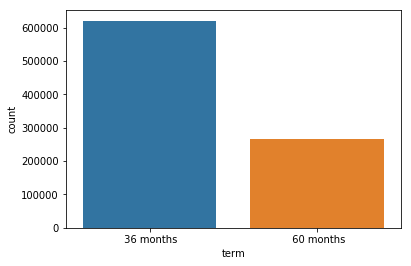

In [19]:
sns.countplot(x='term', data=term_dates)
plt.show()

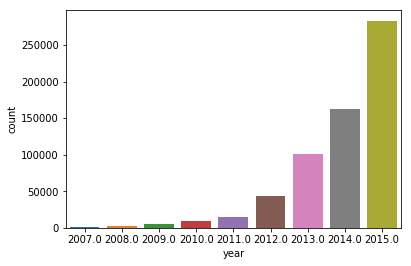

In [20]:
sns.countplot(x='year', data=term_dates.loc[term_dates.term==' 36 months',:])
plt.show()

## Cleaning

In [21]:
data_dict = pd.read_csv(final_data_dict_path, sep='\t')

In [22]:
# Get distinct values for all categoricals to consider collapsing
cat_vars = clean.columns_by_type(data_dict, 'categorical')
categoricals = dict()
for col in cat_vars:
    df = clean.get_distinct_vals(col)
    categoricals[col] = {x:str(x).lower().replace(' ','_') for x in df}
with open('data/json_maps_in.json', 'w') as file:
    file.write(json.dumps(categoricals, indent=4))

Will write to a json file, then manually review and decide if any categorical variables should be renamed or grouped. If so, will edit the file and save as json_maps_out.json and load to use for renaming columns.

In [23]:
# Load the final data dictionary
date_cols = list(data_dict.loc[data_dict.date_format.notnull(),'name'])

# Load the data
if test:
    loan_dat = pd.read_csv(csv_path, low_memory=False, parse_dates=date_cols, nrows=test_load)
else:
    loan_dat = pd.read_csv(csv_path, low_memory=False, parse_dates=date_cols)

# Replace values in categoricals with cleaned, stored in data/json_maps_out.json
with open('data/json_maps_out.json', 'r') as file:
    field_maps = json.load(file)
for column, field_map in field_maps.items():
    loan_dat[column] = loan_dat[column].map(field_map)

loan_dat.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,_36_months,10.65,162.87,b,b2,NaN,10.0,rent,24000.0,verified,2011-12-01,fully_paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,az,27.65,0.0,1985-01-01,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,2015-01-01,171.62,NaT,2016-01-01,0.0,NaN,NaN,individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,_60_months,15.27,59.83,c,c4,Ryder,0.0,rent,30000.0,source_verified,2011-12-01,charged_off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,ga,1.00,0.0,1999-04-01,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,NaT,2013-09-01,0.0,NaN,NaN,individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,_36_months,15.96,84.33,c,c5,NaN,10.0,rent,12252.0,not_verified,2011-12-01,fully_paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,il,8.72,0.0,2001-11-01,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,2014-06-01,649.91,NaT,2016-01-01,0.0,NaN,NaN,individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,_36_months,13.49,339.31,c,c1,AIR RESOURCES BOARD,10.0,rent,49200.0,source_verified,2011-12-01,fully_paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,ca,20.00,0.0,1996-02-01,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,2015-01-01,357.48,NaT,2015-01-01,0.0,NaN,NaN,individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,_60_months,12.69,67.79,b,b5,University Medical Group,1.0,rent,80000.0,source_verified,2011-12-01,current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,or,17.94,0.0,1996-01-01,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,2016-01-01,67.79,2016-02-01,2016-01-01,0.0,NaN,NaN,individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualizations

Review each category of data with a Facets dashboard.

Set the `to_visualize` variable to one of `demographics`, `loan`, `credit`, `LC_calcs`, `outcomes`

If Facets doesn't automatically update data, rerun cell containing `display(HTML(html)`

In [ ]:
to_visualize = 'loan'
html = facets_wrapper.make_facet(loan_dat[clean.columns_by_type(data_dict, to_visualize)], 'name')
display(HTML(html))

# Part 2: Business Analysis

In [24]:
dates = pd.read_csv(csv_path, usecols=['issue_d', 'last_pymnt_d'])
dates = dates.apply(pd.to_datetime, axis=0, format='%b-%Y')
last_issue_date = max(dates.issue_d)
last_paymnt_date = max(dates.last_pymnt_d)
print('Last issue date: '+str(last_issue_date))
print('Last payment date: '+str(last_paymnt_date))

Last issue date: 2015-12-01 00:00:00
Last payment date: 2016-01-01 00:00:00


The last issue date for any loans in the data set is December 2015 and the last payment date for any loans in the data set is January 2016, so we assume that's the last date that we have information about any payments. If we only include loans that have at least 36 months of data, then we need to cut off loans that were issued 36 months prior to December 2015, which is December 2012.

In [25]:
criteria =  loan_dat[((loan_dat.term == '_36_months') & (loan_dat.issue_d <= '2012-12-01'))].index
loan_36 = loan_dat.loc[criteria,:]
print(loan_36.shape)
percent_missing = (((loan_36.isnull().sum(axis=0))/loan_36.shape[0])*100).to_frame()
percent_missing.to_csv('data/percent_missing.csv')

(75004, 74)


In [26]:
# Double check that we have the right set of loans
print(loan_36.groupby('loan_status').size())
print(loan_dat.groupby('loan_status').size())

loan_status
charged_off     9720
current           33
default           12
fully_paid     65146
late              93
dtype: int64
loan_status
charged_off     46009
current        601779
default          1219
fully_paid     209711
issued           8460
late            20201
dtype: int64


## What rate of return have these loans generated on average?

There is occasionally a difference between the total funded amount and the amount funded by investors, and a corresponding difference in total payments and the total payments for investors. To simplify, I will assume we're only interested in total returns.

The formula I will use to calculate average rate of return for the portfolio consisting of the full data set is:

$\text{ROI} = \frac{\text{Total Income}-\text{Total Cost}}{\text{Total Cost}}$

In this data set, $\text{Total Income} = \text{total_pymnt}$ and $\text{Total Cost}=\text{funded_amnt}+\text{collection_recovery_fee}$

In [27]:
loan_36['roi'] = loan_36.apply(clean.roi, axis=1)
print('Mean ROI: '+str(np.mean(loan_36.roi)))

Mean ROI: 0.0877362153497


## When bucketed by year of origination and grade, which cohort had the highest rate of return?

In [28]:
loan_36['year_orig'] = loan_36.apply(lambda x: x['issue_d'].year, axis=1)
loan_36_agg = loan_36.groupby(['year_orig','grade']).agg({'roi':np.mean}).sort_values(by='roi', ascending=False)
loan_36_agg.head()

roi
year_orig grade          
2012      g      0.197439
          f      0.163317
          e      0.149049
2011      e      0.124845
          f      0.122090